In [5]:
!pip install imbalanced-learn


     -------------------------------------- 235.6/235.6 kB 2.1 MB/s eta 0:00:00
     -------------------------------------- 302.2/302.2 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [6]:
#import libraries

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

In [7]:
# Constants
PREPROCESSED_DATA_FOLDER = 'processed_data'
SMOTE_DATA_FOLDER = 'smote_data'
IMG_SIZE = (256, 256)  # Should match the preprocessing size
DISPLAY_CLASS = 'Reshealthy'  # Class to display original and SMOTE images
NUM_SMOTE_IMAGES_TO_DISPLAY = 5  # Number of SMOTE images to display

In [8]:
# Function to load and transform images for SMOTE
def load_and_transform_images(folder_path, img_size):
    images = []
    labels = []
    label_map = {}  # Map class names to integer labels

    for class_idx, class_folder in enumerate(sorted(os.listdir(folder_path))):
        class_path = os.path.join(folder_path, class_folder)
        label_map[class_folder] = class_idx
        for img_filename in os.listdir(class_path):
            img_path = os.path.join(class_path, img_filename)
            img = load_img(img_path, target_size=img_size)
            img = img_to_array(img)
            images.append(img.flatten())  # Flatten image to 1D array
            labels.append(class_idx)
    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, label_map

# Function to apply SMOTE and convert back to images
def apply_smote_and_convert_back(images, labels, label_map):
    smote = SMOTE()
    smote_images, smote_labels = smote.fit_resample(images, labels)

    # Convert back to image format and save
    for idx, (img, label) in enumerate(zip(smote_images, smote_labels)):
        img = img.reshape(IMG_SIZE[0], IMG_SIZE[1], 3)  # Reshape back to image dimensions
        img = Image.fromarray(img.astype('uint8'), 'RGB')
        class_folder = [key for key, value in label_map.items() if value == label][0]
        save_path = os.path.join(SMOTE_DATA_FOLDER, class_folder)
        os.makedirs(save_path, exist_ok=True)
        img.save(os.path.join(save_path, f'smote_{idx}.png'))
        
# Function to display original and SMOTE images
def display_images(image_paths, title):
    plt.figure(figsize=(12, 6))
    for i, img_path in enumerate(image_paths):
        plt.subplot(1, len(image_paths), i + 1)
        img = load_img(img_path)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

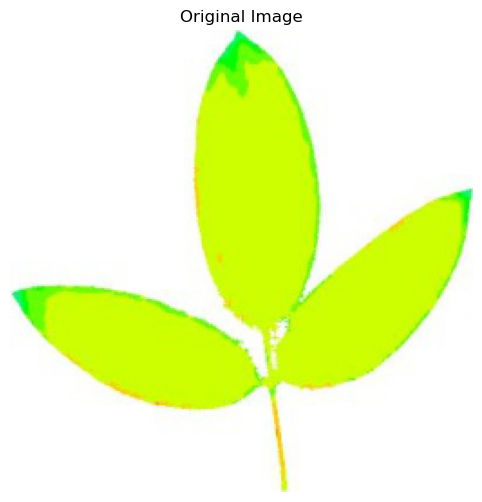

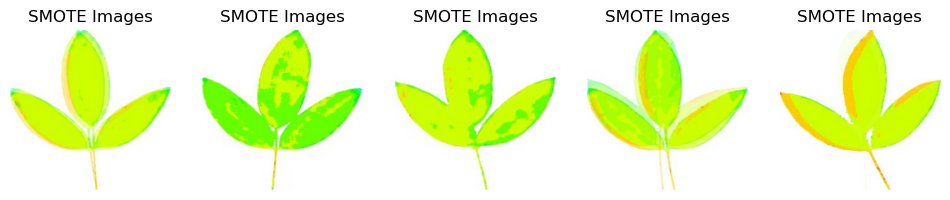

Modhealthy: 128 images
Modinoculated: 128 images
Reshealthy: 128 images
Resinoculated: 128 images
Suschealthy: 128 images
Suscinoculated: 128 images


In [9]:
# Main function
def main():
    images, labels, label_map = load_and_transform_images(PREPROCESSED_DATA_FOLDER, IMG_SIZE)
    apply_smote_and_convert_back(images, labels, label_map)

    # Display original and SMOTE images
    original_image_path = os.path.join(PREPROCESSED_DATA_FOLDER, DISPLAY_CLASS, os.listdir(os.path.join(PREPROCESSED_DATA_FOLDER, DISPLAY_CLASS))[0])
    smote_image_paths = [os.path.join(SMOTE_DATA_FOLDER, DISPLAY_CLASS, img) for img in os.listdir(os.path.join(SMOTE_DATA_FOLDER, DISPLAY_CLASS))[:NUM_SMOTE_IMAGES_TO_DISPLAY]]

    display_images([original_image_path], "Original Image")
    display_images(smote_image_paths, "SMOTE Images")

    # Print the number of images per class
    for class_folder in sorted(os.listdir(SMOTE_DATA_FOLDER)):
        num_images = len(os.listdir(os.path.join(SMOTE_DATA_FOLDER, class_folder)))
        print(f"{class_folder}: {num_images} images")

if __name__ == '__main__':
    main()

In [10]:
# Cell 1: Import Libraries
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Constants
DATA_FOLDER = 'smote_data'
IMG_SIZE = (224, 224)  # Adjust based on ResNet50 requirements
BATCH_SIZE = 32  # Can be adjusted based on your system's capabilities

# Cell 2: Prepare Data
def prepare_data(data_folder, img_size, batch_size):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

    train_generator = datagen.flow_from_directory(
        data_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        data_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False  # Important for correct label ordering in evaluation
    )
    
    return train_generator, validation_generator

# Cell 3: Set Up ResNet50 Model for Transfer Learning
def setup_model(train_data, img_size):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_size + (3,))
    base_model.trainable = False  # Freeze base model layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)  # Adjust the size of the dense layer if needed
    predictions = Dense(train_data.num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Cell 4: Compile and Train the Model
def compile_and_train_model(model, train_data, val_data):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_data,
        steps_per_epoch=train_data.samples // train_data.batch_size,
        validation_data=val_data,
        validation_steps=val_data.samples // val_data.batch_size,
        epochs=10  # Adjust the number of epochs
    )
    return history

# Cell 5: Evaluate the Model
def evaluate_model(model, val_data):
    val_predictions = model.predict(val_data)
    val_labels = np.argmax(val_predictions, axis=1)
    true_labels = val_data.classes
    class_labels = list(val_data.class_indices.keys())

    print("Confusion Matrix")
    print(confusion_matrix(true_labels, val_labels))

    print("\nClassification Report")
    print(classification_report(true_labels, val_labels, target_names=class_labels))

# Cell 6: Main Function to Run the Workflow
def main():
    train_generator, validation_generator = prepare_data(DATA_FOLDER, IMG_SIZE, BATCH_SIZE)
    model = setup_model(train_generator, IMG_SIZE)
    compile_and_train_model(model, train_generator, validation_generator)
    evaluate_model(model, validation_generator)

if __name__ == "__main__":
    main()


Found 618 images belonging to 6 classes.
Found 150 images belonging to 6 classes.
Epoch 1/10
19/19 [==============================] - 47s 2s/step - loss: 3.2075 - accuracy: 0.2338 - val_loss: 1.9943 - val_accuracy: 0.1172
Epoch 2/10
19/19 [==============================] - 47s 2s/step - loss: 1.3436 - accuracy: 0.4727 - val_loss: 1.5948 - val_accuracy: 0.3906
Epoch 3/10
19/19 [==============================] - 50s 3s/step - loss: 1.1347 - accuracy: 0.5683 - val_loss: 1.7678 - val_accuracy: 0.3438
Epoch 4/10
19/19 [==============================] - 51s 3s/step - loss: 1.0101 - accuracy: 0.6160 - val_loss: 1.6525 - val_accuracy: 0.4297
Epoch 5/10
19/19 [==============================] - 48s 3s/step - loss: 0.9106 - accuracy: 0.6536 - val_loss: 1.3794 - val_accuracy: 0.5000
Epoch 6/10
19/19 [==============================] - 48s 3s/step - loss: 0.7877 - accuracy: 0.7338 - val_loss: 1.6347 - val_accuracy: 0.4062
Epoch 7/10
19/19 [==============================] - 48s 3s/step - loss: 0.7052

In [2]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Constants
DATA_FOLDER = 'smote_data'  # Directory with preprocessed and augmented data
IMG_SIZE = (224, 224)  # VGG16 standard image size
BATCH_SIZE = 32

# Function for Preparing Data
def prepare_data():
    # Preprocessing the input 
    datagen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input, validation_split=0.2)

    # Prepare generators
    train_generator = datagen.flow_from_directory(
        DATA_FOLDER,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        DATA_FOLDER,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )
    return train_generator, validation_generator

# Function to Build and Compile the VGG16 Model
def build_vgg16_model(train_data):
    # Load the VGG16 model, pre-trained on ImageNet data
    vgg16_base = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))

    # Freeze the layers
    for layer in vgg16_base.layers:
        layer.trainable = False

    # Add custom layers on top for our specific task
    x = vgg16_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout added
    predictions = Dense(train_data.num_classes, activation='softmax')(x)

    # Compile the model
    model = Model(inputs=vgg16_base.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to Train and Evaluate the Model
def train_and_evaluate(model, train_generator, validation_generator):
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        epochs=10  # Adjust as needed
    )

    # Evaluate the model
    val_predictions = model.predict(validation_generator)
    val_labels = np.argmax(val_predictions, axis=1)
    true_labels = validation_generator.classes
    class_labels = list(validation_generator.class_indices.keys())

    print("Confusion Matrix")
    print(confusion_matrix(true_labels, val_labels))

    print("\nClassification Report")
    print(classification_report(true_labels, val_labels, target_names=class_labels))

# Main execution
def main():
    train_generator, validation_generator = prepare_data()
    vgg16_model = build_vgg16_model(train_generator)
    train_and_evaluate(vgg16_model, train_generator, validation_generator)

if __name__ == '__main__':
    main()


Found 618 images belonging to 6 classes.
Found 150 images belonging to 6 classes.
Epoch 1/10
19/19 [==============================] - 114s 6s/step - loss: 4.5688 - accuracy: 0.2440 - val_loss: 2.3867 - val_accuracy: 0.3203
Epoch 2/10
19/19 [==============================] - 133s 7s/step - loss: 2.5346 - accuracy: 0.3584 - val_loss: 2.4043 - val_accuracy: 0.3125
Epoch 3/10
19/19 [==============================] - 127s 7s/step - loss: 1.6023 - accuracy: 0.4659 - val_loss: 1.5480 - val_accuracy: 0.4297
Epoch 4/10
19/19 [==============================] - 122s 6s/step - loss: 1.1706 - accuracy: 0.5956 - val_loss: 1.3139 - val_accuracy: 0.4922
Epoch 5/10
19/19 [==============================] - 134s 7s/step - loss: 1.0619 - accuracy: 0.6007 - val_loss: 1.3371 - val_accuracy: 0.4922
Epoch 6/10
19/19 [==============================] - 126s 7s/step - loss: 0.8685 - accuracy: 0.6775 - val_loss: 1.2498 - val_accuracy: 0.5156
Epoch 7/10
19/19 [==============================] - 130s 7s/step - loss:

C:\Users\bhumi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bhumi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bhumi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import nasnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Constants
DATA_FOLDER = 'smote_data'  # Directory with preprocessed and augmented data
IMG_SIZE = (224, 224)  # Adjust as per NASNetMobile requirements
BATCH_SIZE = 32

# Function for Preparing Data
def prepare_data():
    # Preprocessing the input 
    datagen = ImageDataGenerator(preprocessing_function=nasnet.preprocess_input, validation_split=0.2)

    # Prepare generators
    train_generator = datagen.flow_from_directory(
        DATA_FOLDER,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        DATA_FOLDER,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )
    return train_generator, validation_generator

# Function to Build and Compile the NASNetMobile Model
def build_nasnet_model(train_data):
    # Load the NASNetMobile model, pre-trained on ImageNet data
    nasnet_base = nasnet.NASNetMobile(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))

    # Freeze the layers
    for layer in nasnet_base.layers:
        layer.trainable = False

    # Add custom layers on top for our specific task
    x = nasnet_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout added
    predictions = Dense(train_data.num_classes, activation='softmax')(x)

    # Compile the model
    model = Model(inputs=nasnet_base.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to Train and Evaluate the Model
def train_and_evaluate(model, train_generator, validation_generator):
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        epochs=10  # Adjust as needed
    )

    # Evaluate the model
    val_predictions = model.predict(validation_generator)
    val_labels = np.argmax(val_predictions, axis=1)
    true_labels = validation_generator.classes
    class_labels = list(validation_generator.class_indices.keys())

    print("Confusion Matrix")
    print(confusion_matrix(true_labels, val_labels))

    print("\nClassification Report")
    print(classification_report(true_labels, val_labels, target_names=class_labels))

# Main execution
def main():
    train_generator, validation_generator = prepare_data()
    nasnet_model = build_nasnet_model(train_generator)
    train_and_evaluate(nasnet_model, train_generator, validation_generator)

if __name__ == '__main__':
    main()


Found 618 images belonging to 6 classes.
Found 150 images belonging to 6 classes.
Epoch 1/10
19/19 [==============================] - 36s 1s/step - loss: 1.9462 - accuracy: 0.2662 - val_loss: 1.6347 - val_accuracy: 0.3203
Epoch 2/10
19/19 [==============================] - 23s 1s/step - loss: 1.5180 - accuracy: 0.3857 - val_loss: 1.5996 - val_accuracy: 0.3594
Epoch 3/10
19/19 [==============================] - 24s 1s/step - loss: 1.4719 - accuracy: 0.3857 - val_loss: 1.5659 - val_accuracy: 0.3594
Epoch 4/10
19/19 [==============================] - 25s 1s/step - loss: 1.3566 - accuracy: 0.4608 - val_loss: 1.7424 - val_accuracy: 0.2812
Epoch 5/10
19/19 [==============================] - 25s 1s/step - loss: 1.3325 - accuracy: 0.4881 - val_loss: 1.5287 - val_accuracy: 0.4297
Epoch 6/10
19/19 [==============================] - 24s 1s/step - loss: 1.2854 - accuracy: 0.5000 - val_loss: 1.4844 - val_accuracy: 0.4062
Epoch 7/10
19/19 [==============================] - 24s 1s/step - loss: 1.2092